**Source Detection**  
@Author: Ray  
@Time: 2022.09.21  
@Cite: [photutils.segmentation](https://photutils.readthedocs.io/en/stable/segmentation.html)  
@Note: 使用image segmentation(图像分割)完成任意源检测(点展源均可)

Image segmentation (图像分割):
* 图像分割是给图像中每个pixel贴标签的过程，告诉每个pixel属于哪个源
* 源应有一个最少相邻像素连接数量，并且每个像素的值都应大于预设的阈值
* 阈值通常通常设置为背景噪声(sigma level)的整数倍

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import SqrtStretch, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize

---
## 生成实验图像

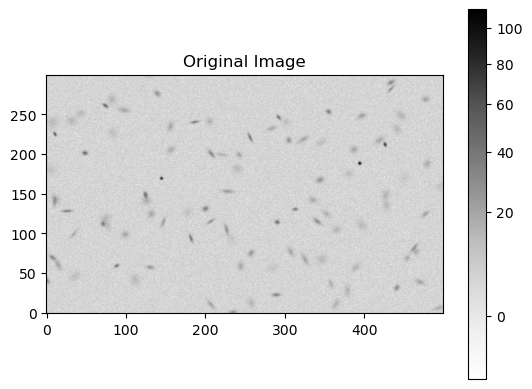

In [21]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys')
plt.title("Original Image")
plt.colorbar()

---
## 制作Segmentation Map
* 作为预处理，首先要估计背景，由此进行背景扣除和阈值估计；然后再做高斯平滑
* 制作segmentation mag 有两种方法：
    1. 方法1: 先用detect_sources函数进行源检测，再用deblend_sources去混叠
    2. 方法2: 使用SourceFinder函数同时完成源检测和去混叠

### 计算背景噪声

5.163614820781302
2.096824681415656


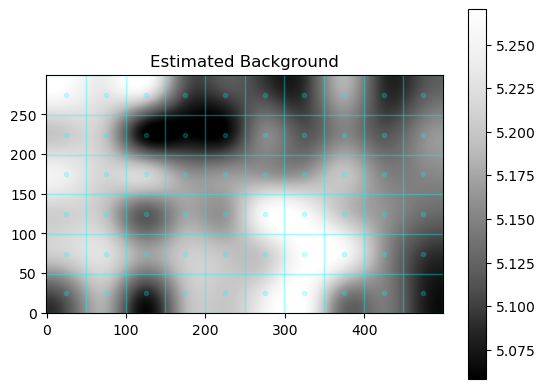

In [22]:
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip

bkg = Background2D(
    data=data, 
    box_size=(50, 50), 
    filter_size=(3, 3),
    sigma_clip=SigmaClip(sigma=3.0), 
    bkg_estimator=MedianBackground()
    )

plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.2)
plt.title("Estimated Background")
plt.colorbar()

print(bkg.background_median)  # 背景噪声的中间值
print(bkg.background_rms_median)  # 背景RMS的中间值

背景扣除

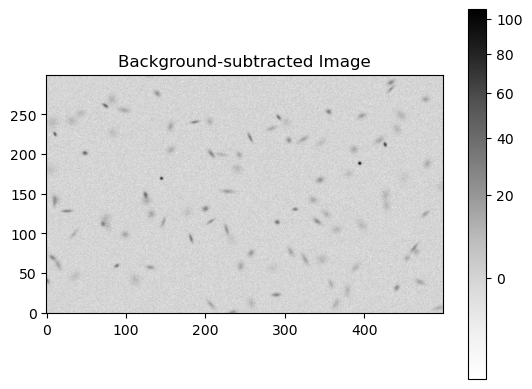

In [23]:
data = data - bkg.background

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys')
plt.title("Background-subtracted Image")
plt.colorbar()

设置检测阈值

In [24]:
threshold = 1.5*bkg.background_rms

### 高斯平滑
* 目的：在源检测前使用高斯kernel平滑图像的背景噪声，并且提高与kernel形状相似的源的检测能力

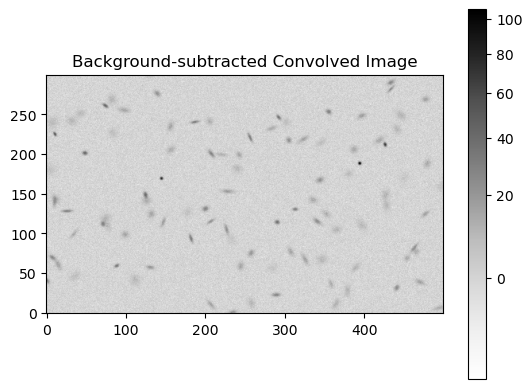

In [25]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.,因此3x3pixels的源的检测能力得到提升
convolved_data = convolve(data, kernel)

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys')
plt.title("Background-subtracted Convolved Image")
plt.colorbar()

### [detect_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources)源检测
* 这一步，只根据阈值和连接最少像素数来划分不同的源，完成源检测
* 有交叠的源会被认为是同一个源，这些源需要在下一步去混叠(deblending)

In [26]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 87
labels: [ 1  2  3  4  5 ... 83 84 85 86 87]


Text(0.5, 1.0, 'Segmentation Image')

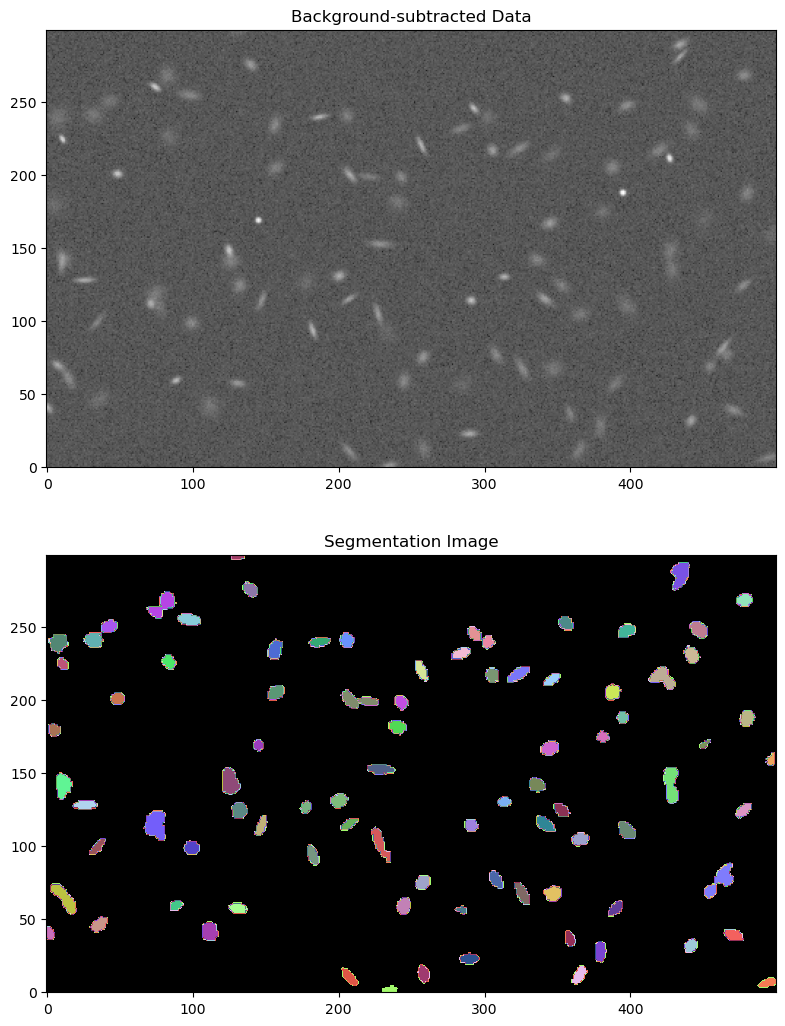

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

norm = ImageNormalize(stretch=SqrtStretch())

ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')

ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap)
ax2.set_title('Segmentation Image')

### [deblend_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html#photutils.segmentation.deblend_sources)去混叠 (Deblending)
* 多阈值算法：SourceExtractor提供的multi-thresholding technique
* 分水岭算法：[Watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing))
* photutils使用这两种算法的结合来做deblending
* deblending的程度由`nlevels`和`contrast`两个参数控制
* `nlevels`: the number of multi-thresholding levels to use
* `contrast`: the fraction of the total source flux that a local peak must have to be considered as a separate object

In [28]:
from photutils.segmentation import deblend_sources

segm_deblend = deblend_sources(
    convolved_data, 
    segment_map, 
    npixels=10, 
    nlevels=32, 
    contrast=0.001,
    progress_bar=True
    )

  0%|          | 0/87 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Deblended Segmentation Image')

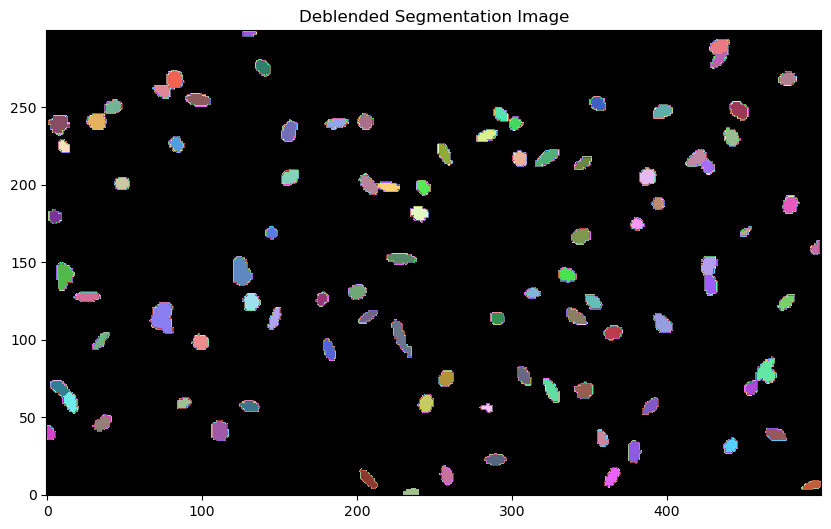

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))

norm = ImageNormalize(stretch=SqrtStretch())

ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap)
ax.set_title('Deblended Segmentation Image')

Plot one of the deblended sources

Text(0.5, 1.0, 'Deblended Segments')

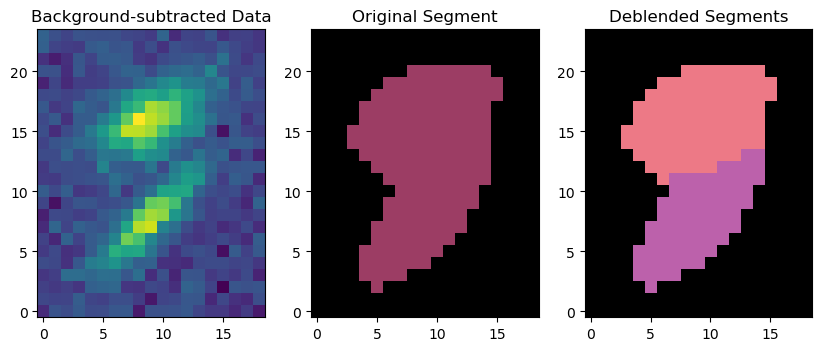

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

norm = ImageNormalize(stretch=SqrtStretch())

slc = (slice(273, 297), slice(425, 444))  # 切片位置: y[273, 297], x[425, 444]

ax1.imshow(data[slc], origin='lower')
ax1.set_title('Background-subtracted Data')

cmap1 = segment_map.cmap
ax2.imshow(segment_map.data[slc], origin='lower', cmap=cmap1)
ax2.set_title('Original Segment')

cmap2 = segm_deblend.cmap
ax3.imshow(segm_deblend.data[slc], origin='lower', cmap=cmap2)
ax3.set_title('Deblended Segments')

### [SourceFinder](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceFinder.html#photutils.segmentation.SourceFinder)一步实现detect和deblend

In [31]:
from photutils.segmentation import SourceFinder

finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 94
labels: [ 1  2  3  4  5 ... 90 91 92 93 94]


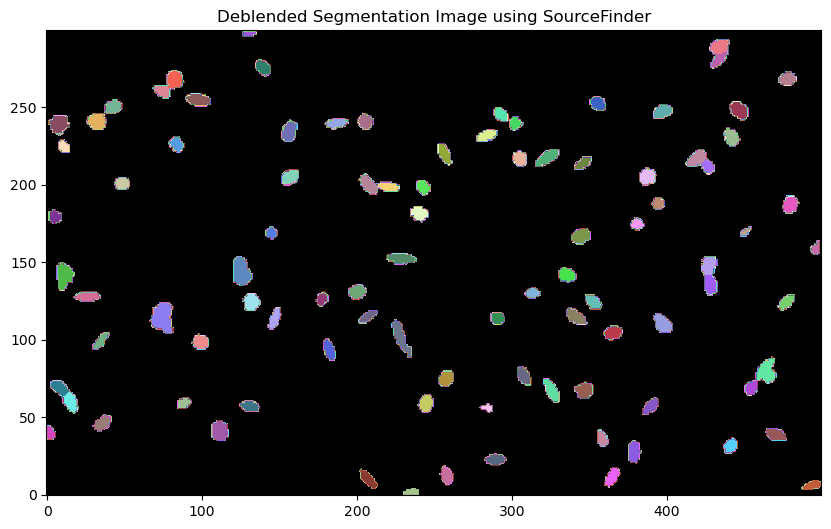

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))

norm = ImageNormalize(stretch=SqrtStretch())

ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap)
ax.set_title('Deblended Segmentation Image using SourceFinder');

---
## 修改Segmentation Image (用到再说)

The SegmentationImage object provides several methods that can be used to visualize or modify itself (e.g., combining labels, removing labels, removing border segments) prior to measuring source photometry and other source properties, including:

- reassign_label(): Reassign one or more label numbers.
- relabel_consecutive(): Reassign the label numbers consecutively, such that there are no missing label numbers.
- keep_labels(): Keep only the specified labels.
- remove_labels(): Remove one or more labels.
- remove_border_labels(): Remove labeled segments near the image border.
- remove_masked_labels(): Remove labeled segments located within a masked region.
- outline_segments(): Outline the labeled segments for plotting.

---
## Source Catalog

### 制作测光星表
输入图像：
1. background-subtracted image
2. segmentation image
3. convolved image

* 可以传入wcs参数，直接计算中心的赤道坐标

In [33]:
from photutils.segmentation import SourceCatalog

cat = SourceCatalog(
    data=data, 
    segment_img=segm_deblend,
    convolved_data=convolved_data 
)

cat # ! 返回的不是table，需要转换

<photutils.segmentation.catalog.SourceCatalog>
Length: 94
labels: [ 1  2  3  4  5 ... 90 91 92 93 94]

In [40]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # 设置数据格式
tbl['ycentroid'].info.format = '.2f'
tbl.show_in_notebook(display_length=5)

idx,label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,,pix2,pix,pix,deg,,,,,,,,
0,1,235.24,1.20,None,230,241,0,4,47.0,2.58358384054832,1.0531992653709408,6.424431433732355,0.91313803076493,0.5952674230935715,22.276738909516045,0.0,445.609472474971,nan,504.7017011353481,nan
1,2,494.00,5.77,None,487,499,3,9,65.0,3.197969128688187,1.3297202787644744,16.30723557506372,0.9094554051158992,0.6907610887801328,15.338411248374701,0.0,471.4889947890731,nan,543.8370095907537,nan
2,3,207.39,9.88,None,202,213,4,16,81.0,3.5009334783170085,1.3310451621032973,-48.617315295336,0.9249054421358025,0.005556588396407491,18.873453570798958,0.0,607.6078980050618,nan,725.0369743940669,nan
3,4,364.84,11.15,None,360,370,5,17,88.0,3.3363310541003033,1.6553005706490749,58.98637407855109,0.8682402606744986,1.2687581064139613,13.579275889334964,0.0,545.7563594816561,nan,710.1322884201957,nan
4,5,258.30,11.90,None,254,262,6,18,79.0,2.958375228365348,1.8133850258982644,-75.9615517651866,0.7901088669347687,0.34613476468812543,12.172334431532477,0.0,472.4108677381284,nan,665.4053634575387,nan
5,6,289.51,22.35,None,283,296,19,26,80.0,2.8596586776191213,1.3709426783460232,0.6172733832097098,0.8775922517362272,-0.2776356407935987,30.593439494193284,0.0,819.7267341550339,nan,870.0908637354574,nan
6,7,379.22,27.33,None,376,383,20,34,93.0,3.418156788161073,1.7557514585623255,87.20374578304687,0.8579971456421782,-0.06842177653074089,14.106664619164711,0.0,552.4904719912225,nan,744.5759638152713,nan
7,8,441.31,31.15,None,437,445,27,36,68.0,2.1518084373811357,1.6101220263801024,52.24435988427467,0.6634004261764945,-1.5801837919646413,25.11082183143418,0.0,687.3535269519593,nan,744.0384670240435,nan
8,9,358.48,35.89,None,356,362,31,41,59.0,2.607801614428664,1.3365623312040316,-74.43120510942701,0.8586725759057503,-0.4837070765488152,14.56328743202075,0.0,389.17203265589274,nan,488.1903777659071,nan


### Plot the Kron apertures

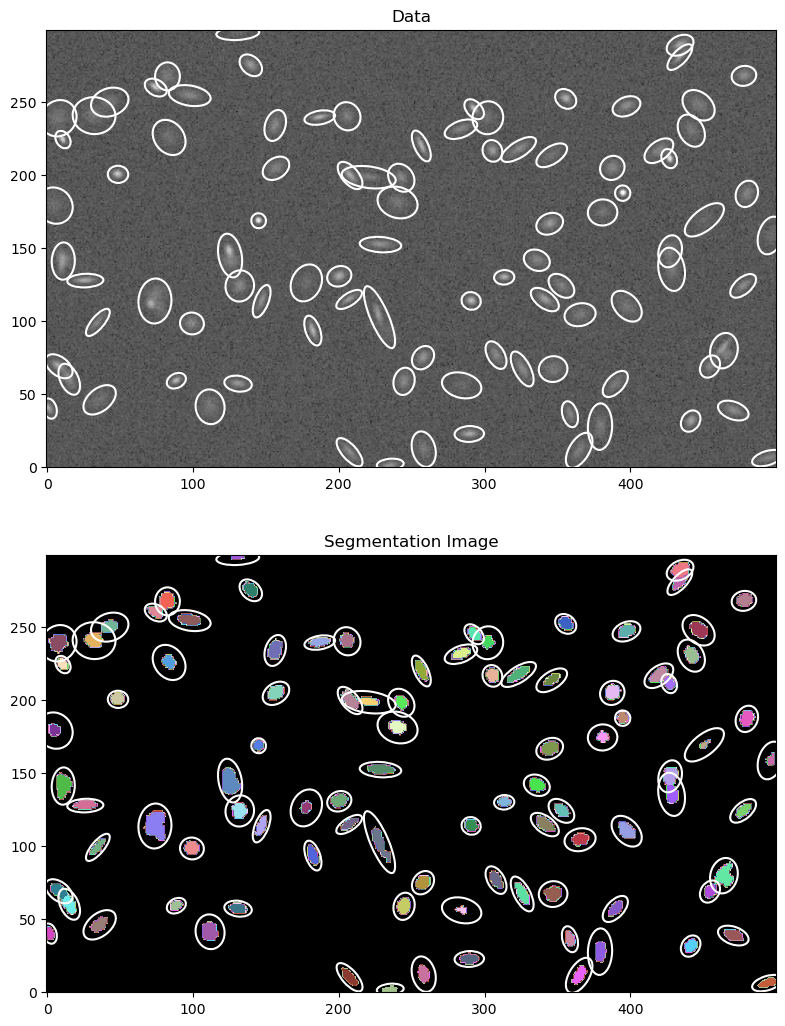

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

norm = ImageNormalize(stretch=SqrtStretch())

ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')

ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap)
ax2.set_title('Segmentation Image')

cat.plot_kron_apertures(axes=ax1, color='white', lw=1.5);
cat.plot_kron_apertures(axes=ax2, color='white', lw=1.5);

### 输出部分星表
* `labels`和`columns`参数

In [36]:
labels = [1, 2, 4, 6, 8, 20, 50]  # 指定源再segm-image中的编号
cols = ['label', 'area', 'segment_flux', 'segment_fluxerr', 'kron_flux', 'kron_fluxerr']  # 需要的列

catalog_subset = cat.get_labels(labels=labels)
tbl_subset = catalog_subset.to_table(columns=cols)
tbl_subset

label,area,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,pix2,,,,
int64,float64,float64,float64,float64,float64
1,47.0,445.609472474971,nan,509.7358700830996,nan
2,65.0,471.4889947890731,nan,544.3055082140767,nan
4,88.0,545.7563594816561,nan,704.2311422569645,nan
6,80.0,819.7267341550339,nan,863.9430315510001,nan
8,68.0,687.3535269519593,nan,745.1272623448624,nan
20,98.0,571.3138360374679,nan,811.7008774077469,nan
50,57.0,257.40702487749127,nan,614.4693996647081,nan


### 测光误差

In [37]:
from photutils.utils import calc_total_error

effective_gain = 500. # 如果image的像素值单位是counts/s，则effective_gain=曝光时间
error = calc_total_error(data=data, bkg_error=bkg.background_rms, effective_gain=effective_gain)

cat = SourceCatalog(data, segm_deblend, error=error)

cols = ['label', 'area', 'segment_flux', 'segment_fluxerr', 'kron_flux', 'kron_fluxerr']  # 需要的列

tbl = cat.to_table(columns=cols)
tbl.show_in_notebook(display_length=5)

idx,label,area,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,pix2,,,,
0,1,47.0,445.609472474971,14.634552526469939,504.7017011353481,19.363344930956227
1,2,65.0,471.4889947890731,16.883789838853573,543.8370095907537,24.085191008351277
2,3,81.0,607.6078980050618,19.178477091024497,725.0369743940669,28.51160579222829
3,4,88.0,545.7563594816561,19.32287540738737,710.1322884201957,36.414828197379045
4,5,79.0,472.4108677381284,19.060457840658668,665.4053634575387,39.006075391784
5,6,80.0,819.7267341550339,19.40372787383494,870.0908637354574,26.620992436483377
6,7,93.0,552.4904719912225,20.13056568020426,744.5759638152713,43.63645452201512
7,8,68.0,687.3535269519593,17.802335685407037,744.0384670240435,24.901684182477975
8,9,59.0,389.17203265589274,16.269913228164285,488.1903777659071,24.523599153439044


### 背景性质
* `background`参数：自动计算每个源的背景

In [38]:
cat = SourceCatalog(
    data=data, 
    segment_img=segm_deblend, 
    background=bkg.background
)
cols = ['label', 'background_centroid', 'background_mean', 'background_sum']
tbl = cat.to_table(columns=cols)
tbl.show_in_notebook(display_length=5)

idx,label,background_centroid,background_mean,background_sum
0,1,5.203561745389382,5.202613746664239,244.52284609321924
1,2,5.270211420828769,5.066400359090818,329.3160233409032
2,3,5.211706012063669,5.202088003216322,421.3691282605221
3,4,5.270211420828769,5.153205908936105,453.48211998637726
4,5,5.238404921067732,5.222974341880805,412.6149730085836
5,6,5.270211420828769,5.2600547705928005,420.80438164742407
6,7,5.269925007025508,5.1530168592702905,479.230567912137
7,8,5.266332457584031,5.130191510564551,348.8530227183894
8,9,5.261499966537846,5.208873448171856,307.3235334421395
9,10,5.214119937543067,5.134199952670952,616.1039943205142
